In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [86]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [87]:
# Check for any null values.
data.isnull().any()

age         False
sex         False
cp          False
trestbps    False
chol        False
fbs         False
restecg     False
thalach     False
exang       False
oldpeak     False
slope       False
ca          False
thal        False
target      False
dtype: bool

## A table explaining the above columns:

- age: Age of the participant in years.
- sex: 1 for male, 0 for female
- cp: Chest pain type
    0 - typical angina: Chest pain caused by a lack of blood flow to the heart.
    1 - atypical angina: A more subtle version of typcal angina - fatigue, feelings of indigestion, moderate             chest pain.
    2 - non-anginal pain: Chest pain not related to any coronary issues.
    3 - asymptomatic: No chest pain at all
- trestbps: Resting blood pressue in mm Hg on admission to the hospital
- chol: serum cholesterol in mg/dl.
- fbs: fasting blood sugar. 1 if 120 mg/dl, and 0 otherwise.
- restecg: Resting electrocardiographic results. 0 indicates normal, and 1 or 2 indicates abnormal.
- thalach: Maximum heart rate achieved.
- exang: Exercise induced angina - 1 for yes, 0 for no.
- oldpeak: ST depression induced by exercise relative to rest.
- slope: Slope of the peak exercise ST segment.
- ca: Number of major vessels colored by flouroscopy.
- thal: 3 = normal, 6 = fixed defect, 7 = reversible defect.
- target: 1 if heart disease present, and 0 otherwise.

# Overview

To begin analyzing this dataset, we consider the following question: Is there a relationship between age,
cholesterol level, and whether or not the patient has heart disease (target)? More specifically, we hypothesize
that older patients with higher cholesterol levels will be the most likely subset of participants to have heart disease. We will proceed with trying to answer this question in two steps:

1. Break up the data into bins corresponding to age groups + (low,moderate,high) cholesterol levels, and see if   there is any significant increase in the likelihood of heart disease as we move up in age and cholesterol.
2. Use three-quarters of the data to build a logistic regression model for predicting heart disease (as a function of age and cholesterol level), and verify the accuracy of the model on the other quarter of the data.
3. If the above model is insufficiently accurate, experiment with adding more predictors to the regression model to improve the accuracy.

However, before proceeding with answering the above question, we look to see if there appears to be any significant correlation between age and cholesterol levels. We do this to ensure that there isn't collinearity in our model.

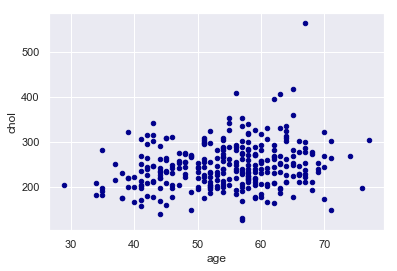

In [88]:
# Plot age against cholesterol level in a scatterplot.
age_chol_scatter = data.plot.scatter('age', 'chol', c='DarkBlue')

Based on the above scatterplot, it looks like age and cholesterol levels aren't strongly correlated.
That said, it would be careless to make such a claim without computing the correlation coefficient between
age and cholesterol. Moreover, the scatterplot shows what appears to be an outlier (chol level > 500). To proceed, we'll do two things.

1. Remove any outliers from the dataset (anything beyond 1.5 IQR below Q1 or above Q3 in cholesterol level).
2. Compute the correlation coefficient between chol and age to determine the extent of their independence.

In [89]:
# Get the IQR for cholesterol data, along with upper and lower bounds.
age_chol_data = data[['age','chol']]
chol_quartiles = age_chol_data['chol'].quantile([0.25, 0.50, 0.75])
chol_IQR = chol_quartiles[0.75] - chol_quartiles[0.25]
lower_chol_bound = chol_quartiles[0.25] - 1.5*chol_IQR
upper_chol_bound = chol_quartiles[0.75] + 1.5*chol_IQR

# Filter data based on values within [lower_chol_bound, upper_chol_bound].
age_chol_data_filtered = age_chol_data.loc[(age_chol_data['chol'] >= lower_chol_bound) & (age_chol_data['chol'] <= upper_chol_bound)]

# See how many values were filtered out.
old_num_rows = age_chol_data.shape[0]
new_num_rows = age_chol_data_filtered.shape[0]
print("Num rows removed due to outliers: ", old_num_rows - new_num_rows)

Num rows removed due to outliers:  5


Now that we have filtered the data and removed any outliers, we can compute the correlation coefficient to see how correlated age and cholesterol level are. We do this below:

In [90]:
# Compute the correlation coefficient between age and chol.
age_chol_corr_coeff = age_chol_data_filtered['age'].corr(age_chol_data_filtered['chol'])
print("Correlation coefficient between age and chol: ", age_chol_corr_coeff)

Correlation coefficient between age and chol:  0.17785334144733822


The above value of ~0.178 indicates a weak correlation between age and cholesterol level. This suggests that collinearity between age and cholesterol won't be a serious issue in considering them as predictor variables for heart disease (target).

Next, we determine precisely the age/cholesterol brackets we should use for characterizing the data. As a reminder, our goal here is to see if there is an increase in the likelihood of heart disease as we move up in age and cholesterol levels.

In [91]:
# Determine which age brackets we should use by looking at IQR.
# Also get the min/max ages to get upper and lower bounds for the brackets.
# TODO: Box and whisker plots.
age_data = data['age']
age_quartiles = age_data.quantile([0.25, 0.5, 0.75])
min_age = age_data.min()
max_age = age_data.max()
print(age_quartiles, "\n")
print("Min age: ", min_age)
print("Max age: ", max_age)

0.25    47.5
0.50    55.0
0.75    61.0
Name: age, dtype: float64 

Min age:  29
Max age:  77


Based on the above quartile values, a natural bracketing scheme for age is the following:

-  [29, 47.5]
-  (47.5, 55]
-  (55, 61]
-  (61, 77]
 
For cholesterol level bracketing (chol), I looked at the guidelines outlined at https://www.medicalnewstoday.com/articles/321519.php. These guidelines seem to indicate that for males/females over the age of 20, 125-200 mg/dl seems to be a healthy range. That said, according to the article, doctors now consider a multitude of other factors in addition to the serum cholesterol level before deciding if a patient's cholesterol level is high. Other resources indicate that between 200-250 mg/dl is borderline high, while anything above 250 is considered unequivocally high.

Before blindly using the above number (125-200 mg/dl) to categorize cholesterol levels, we take a quick look at
the quartile values for chol, along with the min and max values.

In [92]:
# Get min and max values for cholesterol levels.
cholesterol_data = data['chol']
min_chol_level = cholesterol_data.min()
max_chol_level = cholesterol_data.max()
print(chol_quartiles, "\n")
print("Min cholesterol (mg/dl): ", min_chol_level)
print("Max cholesterol (mg/dl): ", max_chol_level)

0.25    211.0
0.50    240.0
0.75    274.5
Name: chol, dtype: float64 

Min cholesterol (mg/dl):  126
Max cholesterol (mg/dl):  564


Based on the above, we'll use the following scheme to categorize the various cholesterol levels

- [126, 200] : Low
- (200, 250]: Moderate
- (250, 564]: High

Next, we bin the data according to the age/cholesterol brackets outlined above.

In [93]:
# Add in columns with the corresponding age and cholesterol categories.
data['age_cat'] = pd.cut(data['age'], [29, 47.5, 55, 61, 77], include_lowest=True)
data['chol_cat'] = pd.cut(data['chol'], [126, 200, 250, 564], labels=['low', 'moderate', 'high'], include_lowest=True)

# Generate a pivot table, where we look at the percentage of cases with heart
# disease in each age/cholesterol category.
percentage_func = lambda x: round(100 * x.sum() / x.count(), 2)
age_chol_hd_table = pd.pivot_table(data, index=['age_cat', 'chol_cat'], values='target', aggfunc=percentage_func)
age_chol_hd_table.columns = ['heart disease percentage']
age_chol_hd_table

heart disease percentage
age_cat        chol_cat                          
(28.999, 47.5] low                          70.00
               moderate                     80.56
               high                         60.00
(47.5, 55.0]   low                          60.00
               moderate                     65.62
               high                         61.76
(55.0, 61.0]   low                          50.00
               moderate                     41.18
               high                         23.53
(61.0, 77.0]   low                          44.44
               moderate                     54.17
               high                         44.74

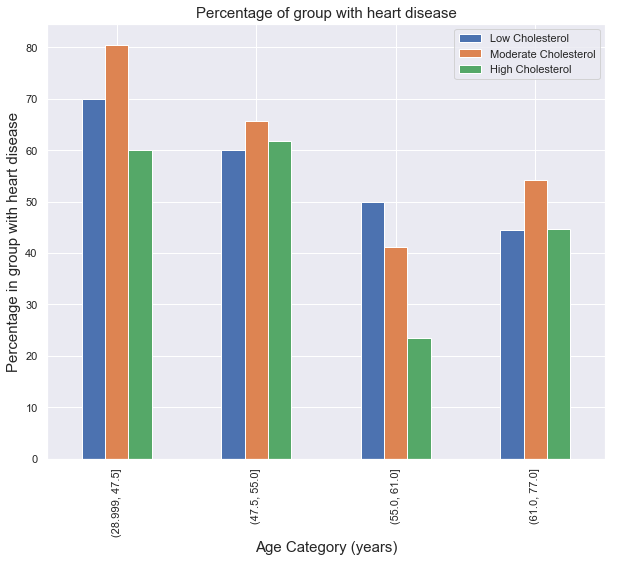

In [94]:
# Visualize the above data by age category with a bar plot.
age_chol_hd_df = age_chol_hd_table.unstack()
ax = age_chol_hd_df.plot(kind='bar', figsize=(10,8))
ax.set_title("Percentage of group with heart disease", fontsize=15)
ax.set_xlabel("Age Category (years)", fontsize=15)
ax.set_ylabel("Percentage in group with heart disease", fontsize=15)
ax.legend(["Low Cholesterol", "Moderate Cholesterol", "High Cholesterol"])
plt.show()

The above plot seems to indicate that, contrary to what was hypothesized, the relationship between age, cholesterol, and heart disease is not as clear-cut as was supposed. In particular, we see that in this dataset, there seems to be an overall decrease in heart-disease percentages in a given age group as we go up in age. Moreover, within a particular age group, those with moderate cholesterol levels had the highest percentage of heart disease incidence (in three of the four age groups). One reason for this last observation might be that the cholesterol levels in the dataset measured serum cholesterol, which is a combination of HDL and LDL cholesterol (LDL is "bad" cholesterol). It is possible that a high serum cholesterol doesn't imply a high LDL cholesterol, which presumably would lead to a higher probability of heart disease.

Next, we use half the dataset to create a logistic regression model to predict heart disease. We build the model with three-quarters of the dataset, and use the other quarter to verify the accuracy of the model. This analysis is shown below.

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Get the necessary data, and split in half for training/test data.
predictors = data[['age', 'chol']]
responses = data[['target']]
pred_train, pred_test, resp_train, resp_test = train_test_split(predictors, responses, test_size=0.25, random_state=0)

# Build the logistic regression model.
logisticRegr = LogisticRegression(solver="lbfgs")
logisticRegr.fit(pred_train, resp_train.values.ravel())

# Use this model on the test data, and determine the accuracy.
accuracy = logisticRegr.score(pred_test, resp_test.values.ravel())
print("The model accuracy is: ", accuracy)

The model accuracy is:  0.6973684210526315


Clearly, given a model accuracy of ~70%, it seems reasonable to suppose that there exists a better model to be found. Before proceeding, however, we first look at using other models, and then determine the feature importance using a random forest classifier to determine precisely which variables would be most useful for a regression model.

Next, we try a different model, in which we use a decision tree to predict heart disease. In particular, we use all columns (besides target) as predictors in the decision tree (minus age categories and cholesterol categories, since this information is already contained in the data implicitly).

In [96]:
from sklearn import tree

# Get the response data, predictor data, and split the data for training/evaluation.
dt_predictors = data[data.columns.difference(['target', 'age_cat', 'chol_cat'])]
dt_response = data[['target']]
pred_train, pred_test, resp_train, resp_test = train_test_split(dt_predictors, dt_response, test_size=0.25, random_state=0)

# Build the decision tree model.
clf = tree.DecisionTreeClassifier()
clf.fit(pred_train, resp_train)

# Use this model on the test data, and determine the accuracy.
accuracy = clf.score(pred_test, resp_test.values.ravel())
print("Decision tree model accuracy: ", accuracy)

Decision tree model accuracy:  0.8026315789473685


From the above, we see an improvement in using a decision tree as opposed to logistic regression. Next, we try using a random forest classifier to see if we can further improve our model accuracy.

In [97]:
# Generate the random forest classifier.
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(pred_train, resp_train.values.ravel())

# Test the model on the test data.
accuracy = clf.score(pred_test, resp_test.values.ravel())
print("Random forest model accuracy: ", accuracy)

Random forest model accuracy:  0.8552631578947368


From the above, we see that we get the highest accuracy if we use a random forest classifier. It is also worth exploring the feature importance as computed by the random forest. This is shown below:

In [98]:
feature_importance = pd.DataFrame(data=clf.feature_importances_, index=pred_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importance

,importance
cp,0.129238
ca,0.125701
oldpeak,0.115953
thalach,0.115330
thal,0.097735
chol,0.085442
age,0.077852
trestbps,0.069410
exang,0.059392
slope,0.049632


Based on the above, we see that cp, ca, and oldpeak are the three most important features as computed by our random forest classifier. Using the above, we recompute our logistic regression model based on these features. This is shown below:

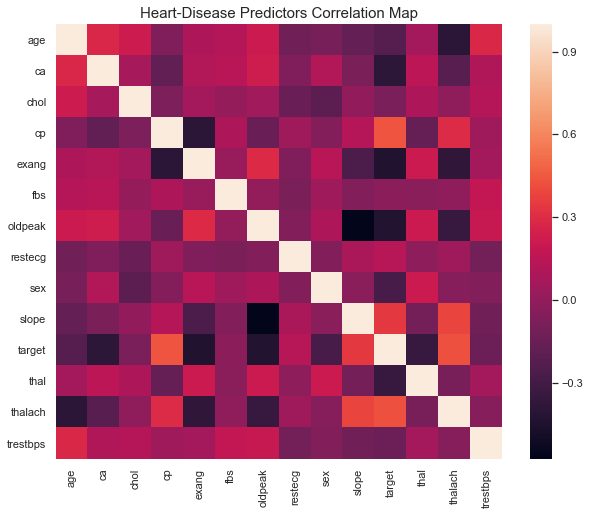

In [99]:
# Visualize the correlation matrix to determine a better set of predictor variables that
# aren't correlated with eachother.
corr_data = data[data.columns.difference(['age_cat', 'chol_cat'])]
corr = corr_data.corr()
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Heart-Disease Predictors Correlation Map", fontsize=15)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)
plt.show()

In [100]:
# Build a new regression model, using ca, cp, and oldpeak as predictor variables.
# Get the necessary data, and split for training/test data.
predictors = data[['ca', 'cp', 'oldpeak']]
responses = data[['target']]
pred_train, pred_test, resp_train, resp_test = train_test_split(predictors, responses, test_size=0.25, random_state=0)

# Build the logistic regression model.
logisticRegr_2 = LogisticRegression(solver="lbfgs")
logisticRegr_2.fit(pred_train, resp_train.values.ravel())

# Use this model on the test data, and determine the accuracy.
accuracy = logisticRegr_2.score(pred_test, resp_test.values.ravel())
print("The model accuracy is: ", accuracy)

The model accuracy is:  0.8026315789473685
